## Topographic profiles

*Doc started 2019-05-12*

These are attempts for calculating topographic profiles directly in a notebook.

As input data we need a DEM and a profile.

In [1]:
%matplotlib inline

### Test case 1

#### DEM input

The source DEM is from the Mt. Alpi zone, based on Aster dati:

In [2]:
source_data = "/home/mauro/Documents/projects/geoprocess/example_data/topo_profiles/malpi_aster_w4u3.tif"

We read the DEM using a wrapper function to GDAL.

In [3]:
from geoprocess.libs_utils.gdal.gdal import read_raster_band

Loading the raster dataset is accomplished with the following function:

In [4]:
band_params = read_raster_band(raster_source=source_data)

In [5]:
print(band_params["success"])

True


We read the data source with success. So we may unpack the result.

In [6]:
dem_geotransform = band_params["geotransform"]
dem_projection = band_params["projection"]
band = band_params["band_params"]
dem_data = band_params["data"]

In [7]:
type(dem_geotransform)

pygsf.spatial.rasters.geotransform.GeoTransform

In [8]:
print(dem_geotransform)

[ 5.80814583e+05  2.72759535e+01  0.00000000e+00  4.44429946e+06
  0.00000000e+00 -2.72759531e+01]


In [9]:
type(dem_projection)

str

In [10]:
print(dem_projection)

PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32633"]]


The DEM projection is UTM zone 33 N.

In [11]:
type(band)

dict

A dictionary, as suspected. Try to see the content..

In [12]:
print(band_params)

{'projection': 'PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32633"]]', 'band_params': {'unitType': '', 'numColorTableEntries': 0, 'noData': 3.4028234663852886e+38, 'stats': {'min': 0.0, 'mean': 1092.0445648248, 'max': 1829.0, 'std_dev': 302.5523744617}, 'numOverviews': 0, 'dataType': 'Float32'}, 'geotransform': GeoTransform(topLeftX: 580814.58, topLeftY: 4444299.46, pixWidth: 27.28, pixHeight: -27.28, rotRow: 0.00, rotColumn: 0.00), 'message': '', 'su

Stats are not calculated.

In [13]:
type(dem_data)

numpy.ndarray

In [14]:
dem_data.shape

(260, 213)

In [15]:
dem_data.min()

0.0

In [16]:
dem_data.max()

1829.0

Given these data, we store them into a GeoArray, a class imported from *pygsf.spatial.rasters.geoarray*:

In [17]:
from pygsf.spatial.rasters.geoarray import GeoArray
ga = GeoArray(inGeotransform=dem_geotransform, inProjection=dem_projection, inLevels=[dem_data])

We plot the grid.

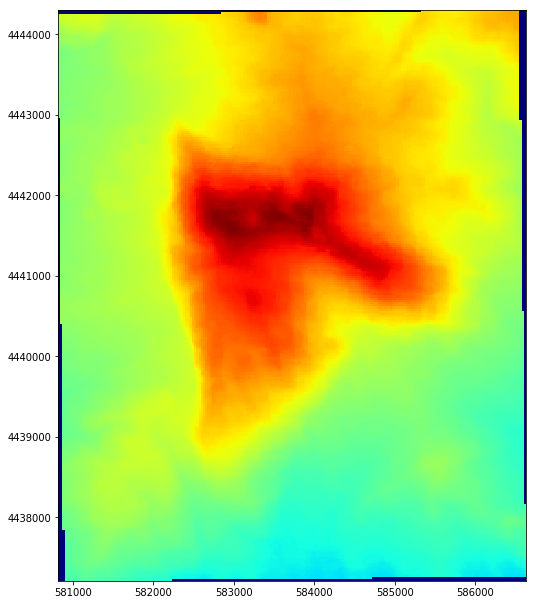

In [18]:
from geoprocess.plotting.maps import plot_grid
fig = plot_grid(ga)

#### Source profile

We get the source profile from a line shapefile. It is a single line, in WGS 84 - UTM 33 N.

In [19]:
src_profile_shapefile_pth = "/home/mauro/Documents/projects/geoprocess/example_data/topo_profiles/profile.shp"

In [20]:
from geoprocess.libs_utils.gdal.ogr import read_line_shapefile_via_ogr
profile_ln = read_line_shapefile_via_ogr(src_profile_shapefile_pth)

In [21]:
print(profile_ln["success"])

True


In [22]:
prof_projection, prof_extent, prof_vertices = profile_ln["projection"], profile_ln["extent"], profile_ln["vertices"]

In [23]:
print(prof_projection)

PROJCS["WGS_1984_UTM_Zone_33N",
    GEOGCS["GCS_WGS_1984",
        DATUM["WGS_1984",
            SPHEROID["WGS_84",6378137,298.257223563]],
        PRIMEM["Greenwich",0],
        UNIT["Degree",0.017453292519943295],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",15],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["Meter",1],
    AUTHORITY["EPSG","32633"]]


The spatial reference of the line profile is the same as the raster DEM: WGS1984 - UTM 33 N. So no projection conversion is required to derive a grid.

Now we turn to examining the profile points.

In [24]:
type(prof_vertices)

list

In [25]:
for rec in prof_vertices:
    for val in rec:
        print(val, type(val))

(581981.1880084907, 4442999.214382717, 0.0) <class 'tuple'>
(586203.5722844116, 4440126.190468659, 0.0) <class 'tuple'>


In [26]:
len(prof_vertices)

1

In [27]:
print(prof_vertices)

[[(581981.1880084907, 4442999.214382717, 0.0), (586203.5722844116, 4440126.190468659, 0.0)]]


We convert the vertices to a Line instance:

In [28]:
from pygsf.spatial.vectorial.vectorial import Line
line = Line.fromPointList(pt_list = prof_vertices[0], crs = prof_projection)

And we add the line in the previous map.

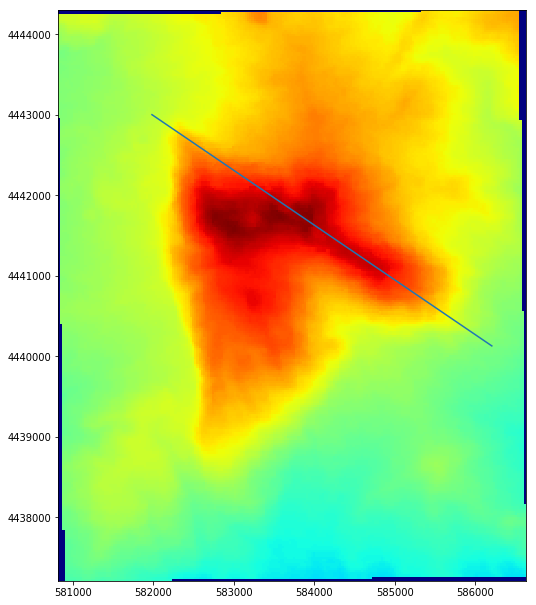

In [29]:
from geoprocess.plotting.maps import plot_line
plot_line(fig, line)

#### Steps for profile calculation

We define a line densification value, equal to 100 m.

In [30]:
line_dens_step = 100 # meters

In [31]:
resampled_line = line.densify_2d_line(line_dens_step)  # Line instance

In [32]:
from pygsf.spatial.vectorial.vectorial import Point

crs = resampled_line.crs
lnProfile = Line(crs=crs)

for point in resampled_line.pts:

    fInterpolatedZVal = ga.interpolate_bilinear(point.x, point.y)

    pt3dt = Point(
        x=point.x,
        y=point.y,
        z=fInterpolatedZVal,
        crs=crs)

    lnProfile.add_pt(pt3dt)

We create a TopoProfile instance, storing the topographic profile object.

In [33]:
from pygsf.profiles.profiles import TopoProfile
topo_profile = TopoProfile(lnProfile)

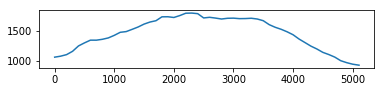

In [34]:
from geoprocess.plotting.profiles import plot_topoprofile
plot_topoprofile(topo_profile)

##### Doc version: 2019-06-10